# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from scipy.interpolate import splrep, BSpline # for Spline graphs
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools.tools import add_constant  # Import the add_constant function
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   '

# Per-Task Linear Models
This notebook contains univariate linear models models to show how different independent variables relate to the dependent variable(s) of interest, for each task.


In [3]:
# For manually fitting and visualizing linear models
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

def plot_single_linear_model(conversation_data, x_vars, y_vars, num_top_plots=None):
    num_plots = len(x_vars) * len(y_vars)
    num_rows = len(y_vars)
    num_cols = len(x_vars)
    num_plots_per_row = min(5, num_cols)

    num_rows_needed = math.ceil(num_plots / num_plots_per_row)
    fig_height = num_rows_needed * 5
    fig_width = num_plots_per_row * 5

    plt.figure(figsize=(fig_width, fig_height))
    
    plot_num = 1    
    all_metrics = []

    for y_var in y_vars:
        for x_var in x_vars:
            x_data = conversation_data[x_var].values.reshape(-1, 1)
            y_data = conversation_data[y_var].values

            # Fit linear regression model
            model = LinearRegression()
            model.fit(x_data, y_data)

            # Predict using the model
            y_pred = model.predict(x_data)

            # Calculate metrics
            r_squared = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            mae = mean_absolute_error(y_data, y_pred)
            all_metrics.append((x_var, y_var, r_squared, mse, mae))
            
            if num_top_plots is None or plot_num <= num_top_plots:
                plt.subplot(num_rows_needed, num_plots_per_row, plot_num)
                sns.scatterplot(x=x_var, y=y_var, data=conversation_data)
                plt.plot(x_data, y_pred, color='red')
                    
                plot_num += 1
                
                if plot_num > num_plots:
                    break
    
    plt.tight_layout()
    plt.show()
    
    metrics_df = pd.DataFrame(all_metrics, columns=['x_var', 'y_var', 'r_squared', 'mse', 'mae']).sort_values(by='r_squared', ascending=False)
    if num_top_plots is not None:
        metrics_df = metrics_df.head(num_top_plots)

    return(metrics_df)

# Example call
# r2_jury_simple_models = plot_single_linear_model(juries_model.conv, juries_model.conv.drop(["target_raw", "target_std"], axis = 1), ["target_std"], num_top_plots=10)

In [4]:
def convert_metrics_dict_to_sorted_df(data):
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(data).T

    # Reset index to move the 'feature' names to a column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'feature'}, inplace=True)

    # Sort the DataFrame by 'r2' values in descending order
    df_sorted = df.sort_values(by='r2', ascending=False)

    # Reorder the columns as required
    columns_order = ['feature', 'r2', 'mae', 'mse', 'rmse']
    df_sorted = df_sorted[columns_order]
    return(df_sorted)

In [5]:
def repeated_kfold_cv_simplelinear(model, k = 10, seed = 19104):

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    feature_metric_dictionary = {}

    # Assumes that we already called split datasets before we called this function!
    all_features = model.X.columns # include all possible features at this stage

    # set up to store results for this feature
    for feature in all_features:
        feature_metric_dictionary[feature] = {"train": None, "test": None}
        feature_metric_dictionary[feature]["train"] = pd.DataFrame(columns=metrics)
        feature_metric_dictionary[feature]["test"] = pd.DataFrame(columns=metrics)

    # Outer loop --- repeat this k times for k-fold CV
    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    for i in range(len(random_states_list)):
        # create an entirely different train-test split for each random iteration
        model.get_split_datasets(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i])

        # Save X_train, y_train, X_val, and y_val so that we don't have to split anew every time
        X_train = model.X_train
        X_val = model.X_val
        y_train = model.y_train
        y_val = model.y_val
        
        # Fit a single linear regression on each of the features and report the results
        for feature in model.X_train: # do this only for the features that made it into this split
            # train a linear regression on just this one feature
            evaluation_metrics = model.train_simple_model(model.baseline_model, feature_subset = [feature])
            # store the results for that feature
            feature_metric_dictionary[feature]["train"] = feature_metric_dictionary[feature]["train"].append(evaluation_metrics['train'], ignore_index=True)
            feature_metric_dictionary[feature]["test"] = feature_metric_dictionary[feature]["test"].append(evaluation_metrics['val'], ignore_index=True)
            # reset the train-test-split, as the underlying X_test got modified
            model.set_datasets(X_train=X_train, y_train = y_train, X_val = X_val, y_val = y_val)

    # Get mean metrics for each feature
    '''
    Optimal format:

    feature 1    r2   mae   mse  rmse
    feature 2    r2   mae   mse  rmse
    feature 3    r2   mae   mse  rmse
    '''
    final_feature_metrics_train = {}
    final_feature_metrics_test = {}

    for feature in feature_metric_dictionary.keys():
        final_feature_metrics_train[feature]=feature_metric_dictionary[feature]["train"].mean()
        final_feature_metrics_test[feature]=feature_metric_dictionary[feature]["test"].mean()

    return final_feature_metrics_train, final_feature_metrics_test


In [6]:
# heteroskedasticity?
def get_heteroskedasticity_test(x, y):
    x_with_const = add_constant(x)  # Add a constant term to x
    model = sm.OLS(y, x_with_const).fit()
    #perform White's test
    white_test = het_white(model.resid,  model.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    return(dict(zip(labels, white_test)))

# Estimation

### Full Data (100%)

In [7]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["reverse_median_post_discussion_error_pct", "reverse_median_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'linear')

estimation_blended_model.get_split_datasets(estimation_blended_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model)
estimation_blended_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
663,stdev_user_sum_content_word_accommodation,-0.0126,0.7385,1.7852,1.3361
36,stdev_discrepancies,-0.0148,0.7316,1.789,1.3375
1083,stdev_user_avg_hashedge,-0.017,0.7466,1.7929,1.339
403,stdev_user_sum_num_words,-0.0208,0.7499,1.7997,1.3415
410,average_user_sum_num_messages,-0.022,0.7733,1.8017,1.3423
650,average_user_sum_word_TTR,-0.0223,0.7754,1.8022,1.3425
174,max_money,-0.0228,0.763,1.8032,1.3428
629,max_user_sum_positive_words,-0.0244,0.7359,1.806,1.3439
622,average_user_sum_second_person,-0.0255,0.7646,1.8079,1.3446
473,max_user_sum_swear,-0.0259,0.7387,1.8087,1.3449


In [21]:
estimation_blended_train_metrics.head(10).to_csv('./top_features_from_simple_reg/estimationNEW_top_10.csv')

In [24]:
estimation_blended_test_metrics.head(10).to_csv('./top_features_from_simple_reg/validation/estimationNEW_top_10.csv')

In [22]:
get_heteroskedasticity_test(estimation_blended_model.conv["stdev_user_sum_content_word_accommodation"], estimation_blended_model.conv["target_std"])

{'Test Statistic': 0.02128931105175802,
 'Test Statistic p-value': 0.9894117983315711,
 'F-Statistic': 0.01037126613392441,
 'F-Test p-value': 0.9896832719503824}

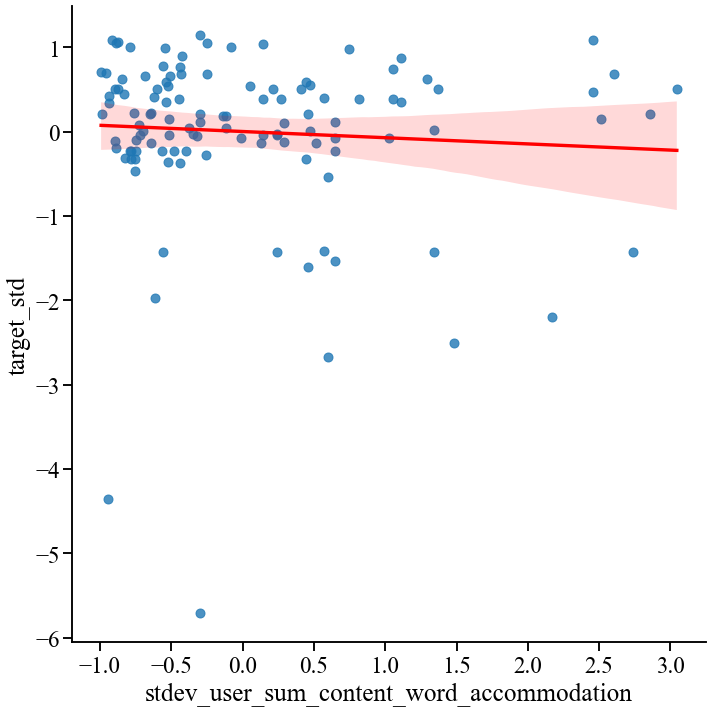

In [23]:
# look at some correlations
sns.lmplot(estimation_blended_model.conv, x = "stdev_user_sum_content_word_accommodation", y = "target_std", line_kws={'color': 'red'}, height = 10)
plt.savefig('./figures/estimationNEW_stdev_user_sum_content_word_accommodation	_lmplot.svg')

### 75% Data

In [11]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["reverse_median_post_discussion_error_pct", "reverse_median_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'linear')

estimation_blended_model75.get_split_datasets(estimation_blended_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model75)
estimation_blended_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
663,stdev_user_sum_content_word_accommodation,-0.0126,0.7385,1.7852,1.3361
1083,stdev_user_avg_hashedge,-0.017,0.7466,1.7929,1.339
34,max_info_exchange_zscore_conversation,-0.0179,0.7595,1.7945,1.3396
403,stdev_user_sum_num_words,-0.0208,0.7499,1.7997,1.3415
3,average_positive_bert,-0.02145,0.75645,1.8909,1.3746
410,average_user_sum_num_messages,-0.022,0.7733,1.8017,1.3423
650,average_user_sum_word_TTR,-0.0223,0.7754,1.8022,1.3425
42,max_hear,-0.0238,0.7773,1.805,1.3435
629,max_user_sum_positive_words,-0.0244,0.7359,1.806,1.3439
622,average_user_sum_second_person,-0.0255,0.7646,1.8079,1.3446


In [12]:
estimation_blended_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/estimationNEW75_top_10.csv')

In [25]:
estimation_blended_test_metrics75.head(10).to_csv('./top_features_from_simple_reg/validation/estimationNEW75_top_10.csv')

### 50% Data

In [13]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["reverse_median_post_discussion_error_pct", "reverse_median_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'linear')

estimation_blended_model50.get_split_datasets(estimation_blended_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model50)
estimation_blended_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
663,stdev_user_sum_content_word_accommodation,-0.0126,0.7385,1.7852,1.3361
139,average_relative,-0.0155,0.7551,1.7902,1.338
1083,stdev_user_avg_hashedge,-0.017,0.7466,1.7929,1.339
86,max_swear,-0.018,0.7413,1.7948,1.3397
403,stdev_user_sum_num_words,-0.0208,0.7499,1.7997,1.3415
410,average_user_sum_num_messages,-0.022,0.7733,1.8017,1.3423
650,average_user_sum_word_TTR,-0.0223,0.7754,1.8022,1.3425
629,max_user_sum_positive_words,-0.0244,0.7359,1.806,1.3439
622,average_user_sum_second_person,-0.0255,0.7646,1.8079,1.3446
473,max_user_sum_swear,-0.0259,0.7387,1.8087,1.3449


In [14]:
estimation_blended_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/estimationNEW50_top_10.csv')

In [18]:
estimation_blended_test_metrics50.head(10).to_csv('./top_features_from_simple_reg/validation/estimationNEW50_top_10.csv')

### 25% Data

In [15]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["reverse_median_post_discussion_error_pct", "reverse_median_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'linear')

estimation_blended_model25.get_split_datasets(estimation_blended_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model25)
estimation_blended_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
663,stdev_user_sum_content_word_accommodation,-0.0126,0.7385,1.7852,1.3361
1083,stdev_user_avg_hashedge,-0.017,0.7466,1.7929,1.339
86,max_swear,-0.0188,0.7446,1.7961,1.3402
84,stdev_swear,-0.0197,0.7451,1.7977,1.3408
83,average_swear,-0.0205,0.7455,1.7992,1.3413
403,stdev_user_sum_num_words,-0.0208,0.7499,1.7997,1.3415
410,average_user_sum_num_messages,-0.022,0.7733,1.8017,1.3423
650,average_user_sum_word_TTR,-0.0223,0.7754,1.8022,1.3425
629,max_user_sum_positive_words,-0.0244,0.7359,1.806,1.3439
622,average_user_sum_second_person,-0.0255,0.7646,1.8079,1.3446


In [16]:
estimation_blended_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/estimationNEW25_top_10.csv')

In [17]:
estimation_blended_test_metrics25.head(10).to_csv('./top_features_from_simple_reg/validation/estimationNEW25_top_10.csv')